In [5]:
%matplotlib inline

import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import geopandas as gpd
plt.rcParams['figure.figsize'] = (15,9)
from rasterstats import zonal_stats
from rasterio.transform import Affine
from scipy.interpolate import griddata
import rasterio
from matplotlib.patches import Rectangle

In [6]:
import scipy.stats

In [7]:
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap

In [8]:
shapefile= gpd.read_file('greatlakes_subbasins.shp')

In [9]:
ds1 = xr.open_dataset('zg_Amon_MIROC-ES2L_historical_r1i1p1f2_gn_185001-201412.nc')
hgt = ds1.zg.sel(lat=slice(-9.87,87.88), lon=slice(182.5, 360),plev=slice(6) ,time=slice('1979-01-01','2014-12-31'))
lat_zg = ds1.lat.sel(lat=slice(-9.86,87.88))
lon_zg = ds1.lon.sel(lon=slice(182.5, 360))

In [10]:
hgt2d = hgt.values
ntime,nlevel, nrow_zg, ncol_zg = hgt2d.shape
print(nrow_zg,ncol_zg)

36 63


In [11]:
a= pd.read_csv("z_anom_miroc.csv")
b=pd.read_csv("miroc_anom_mean.csv")
b

Unnamed: 0      Erie     Huron  Michigan   Ontario  superior
0            1  3.199075  1.208613  1.191158  2.346786  1.796939
1            2  5.503214  1.219377  1.207538  3.335793  1.058386
2            3  4.559606  1.571514  1.190537  3.930076  1.258016
3            4  3.295598  2.101639  1.735740  2.142657  2.253297
4            5  3.511337  2.114104  1.993720  4.252898  1.419212
5            6  2.905410  1.478425  0.949209  2.384413  1.031086
6            7  2.992377  2.217345  2.253813  2.710830  2.887526
7            8  3.683879  2.495580  2.021939  4.253981  2.479072
8            9  3.642609  2.493427  1.683225  3.650603  1.426024
9           10  2.531969  1.602650  0.853684  3.194822  1.232433
10          11  2.072495  2.081757  1.677806  3.431606  1.332047
11          12  3.134457  2.042936  1.726515  3.026961  1.307998
12          13  2.146694  1.393571  1.004986  2.612305  2.530089
13          14  3.400481  1.127138  0.933798  2.138969  1.108882
14          15  3.486718  2.178220  1.702687  3.375393  1.546579
15          16  4.252171  1.539611  1.370473  2.420271  1.392535
16          17  2.321164  2.053529  1.686936  2.982783  1.277048
17          18  1.917463  1.681127  1.395168  3.180831  0.812825
18          19  3.367395  2.607010  1.820521  3.717712  1.812422
19          20  3.972148  1.565747  1.357975  2.267103  1.118669
20          21  3.269386  0.899170  0.386736  3.103814  0.837880
21          22  3.870771  2.091741  1.684809  3.205782  1.688439
22          23  4.128049  1.691694  1.342738  2.919912  2.142676
23          24  3.837943  1.276919  0.811415  3.794103  0.940118
24          25  3.724303  1.523320  0.892354  3.290088  1.034794
25          26  2.955898  2.124655  2.043112  3.628439  1.190743
26          27  3.332604  1.555714  0.765747  4.013052  1.464738
27          28  2.290720  1.990482  1.584208  3.784637  1.449603
28          29  4.182911  2.519458  1.761765  3.986139  1.566960
29          30  2.608968  1.850825  1.359004  2.210476  0.947310
30          31  4.015394  1.311060  1.168834  3.600175  0.820758
31          32  3.612200  0.976932  1.070661  1.936736  1.496949
32          33  3.552603  1.480954  0.899632  3.437547  0.911084
33          34  4.200974  2.145973  1.985254  3.418100  1.376062
34          35  3.573453  1.674220  1.491419  3.814424  1.307467
35          36  4.814769  2.188030  1.973862  4.095895  1.505641

In [12]:
a= a.drop(['Unnamed: 0'],axis=1)
b= b.drop(['Unnamed: 0'],axis=1)
b['mean']= b.mean(axis=1)
a_t= a.T

In [13]:
a_zg = PCA(n_components=9)
a_zg.fit(a_t)
a_reduced= a_zg.transform(a_t)
zg_f=a_zg.inverse_transform(a_reduced)
print(a_zg.explained_variance_ratio_.sum())

0.8499725918509392


In [14]:
rp= np.reshape(zg_f,(nrow_zg,ncol_zg,36),order='F')
range(rp.shape[0])

range(0, 36)

In [15]:
cor_miroc= np.empty((nrow_zg,ncol_zg),dtype=object)
cor_miroc[:] = np.nan
cor_miroc_p= np.empty((nrow_zg,ncol_zg),dtype=object)
cor_miroc_p[:] = np.nan

In [16]:
for i in range((rp.shape[0])):
    for j in range((rp.shape[1])):
        cor_miroc[i,j] = scipy.stats.spearmanr(rp[i,j,],b['mean'])[0]
        
        
        

In [17]:
for i in range((rp.shape[0])):
    for j in range((rp.shape[1])):
        cor_miroc_p[i,j] = scipy.stats.spearmanr(rp[i,j,],b['mean'])[1]
        

In [31]:
miroc_sign= np.zeros([36,63])

In [32]:
for i in range(miroc_sign.shape[0]):
    for j in range(miroc_sign.shape[1]):
        if cor_miroc_p[i,j]<0.1:
            miroc_sign[i,j]= miroc_sign[i,j]+1
        else:
            miroc_sign[i,j]= miroc_sign[i,j]+0

In [33]:
y,x=np.where(miroc_sign>0)


In [34]:
x_list1= x.tolist()
y_list1=y.tolist()
lat_np= lat_zg.to_numpy()
lat_ls= lat_np.tolist()
lon_np=lon_zg.to_numpy()
lon_ls= lon_np.tolist()

In [35]:
lat_list1= []
for values in list(range(len(y_list1))):
    lat_list1.append(lat_ls[y_list1[values]])
    

In [36]:
lon_list1= []
for values in list(range(len(x_list1))):
    lon_list1.append(lon_ls[x_list1[values]])

In [37]:
lat_list1

[46.04472663110168,
 46.04472663110168,
 46.04472663110168,
 46.04472663110168,
 46.04472663110168,
 48.83524096625059,
 65.57760701082782,
 65.57760701082782,
 65.57760701082782,
 65.57760701082782,
 68.36775610831317,
 68.36775610831317,
 68.36775610831317,
 68.36775610831317,
 68.36775610831317,
 71.15775201158732,
 71.15775201158732,
 71.15775201158732,
 71.15775201158732,
 71.15775201158732,
 71.15775201158732,
 71.15775201158732,
 71.15775201158732,
 71.15775201158732,
 71.15775201158732,
 73.94751515398967,
 73.94751515398967,
 73.94751515398967,
 73.94751515398967,
 73.94751515398967,
 73.94751515398967,
 73.94751515398967,
 73.94751515398967,
 73.94751515398967,
 76.73689968036831,
 76.73689968036831,
 76.73689968036831,
 76.73689968036831,
 76.73689968036831,
 76.73689968036831,
 76.73689968036831,
 76.73689968036831,
 79.52560657265944,
 79.52560657265944,
 79.52560657265944,
 79.52560657265944,
 79.52560657265944,
 79.52560657265944,
 79.52560657265944,
 82.31291294788628,


In [38]:
xmax,ymin,xmin,ymax= shapefile.total_bounds
d1=xmax-xmin
d2=ymax-ymin
rect =Rectangle((xmin, ymin), d1, d2, facecolor="none", ec='k', lw=2)

In [39]:
cor_miroc.max()

0.4007722007722008

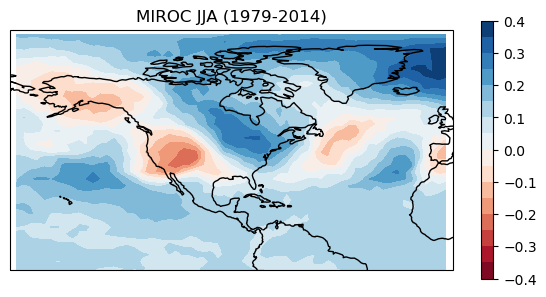

In [41]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)

ax2 = fig.add_subplot(gs[0,1],  projection=ccrs.PlateCarree())
x1, y1 = np.meshgrid(lon_zg, lat_zg)
level= np.arange(-0.4,0.45,0.05)
cs = ax2.contourf(x1, y1, cor_miroc,level,
                        
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu')
    
cb=fig.colorbar(cs, ax=ax2, shrink=0.8, aspect=20)  
#ax2.scatter(lon_list1,lat_list1,marker='o', color='tab:red')
ax2.coastlines()
ax2.set_global()
ax2.set_extent([-180,0,-7.5,90],crs=ccrs.PlateCarree())
ax2.set_title('MIROC JJA (1979-2014)')
#ax2.add_patch(rect)
fig.savefig('basin_mpi')

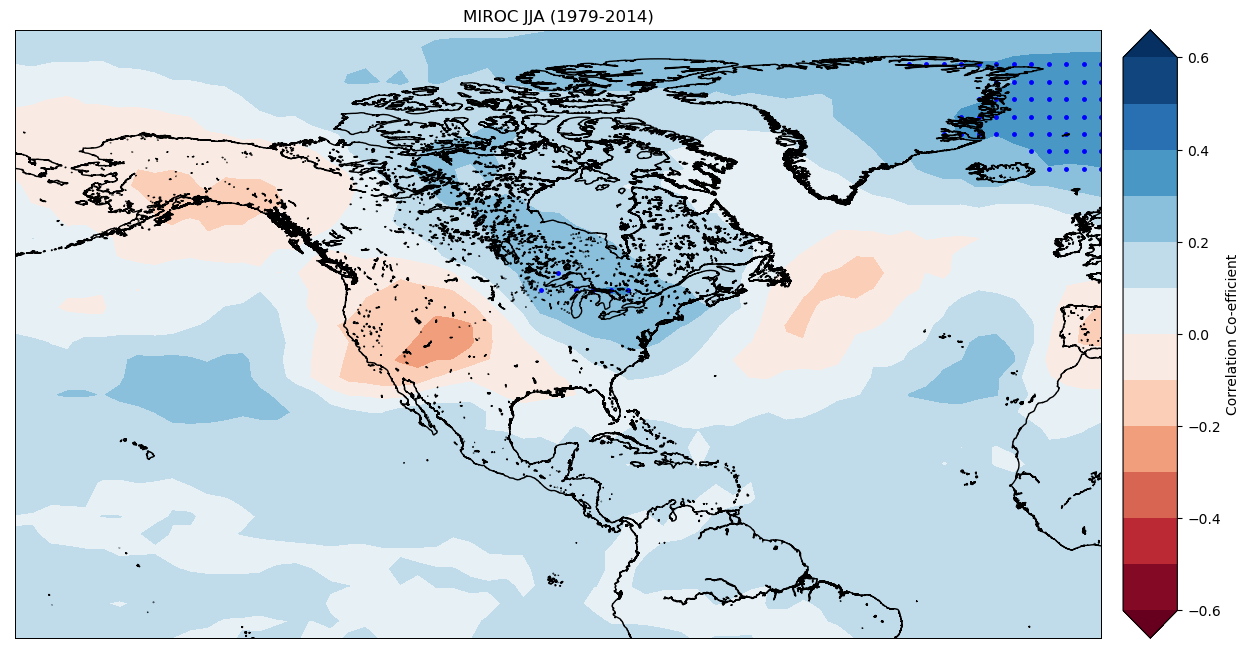

In [43]:
m = Basemap(projection='cyl', llcrnrlon=min(lon_zg), llcrnrlat=min(lat_zg),
        urcrnrlon=max(lon_zg), urcrnrlat=max(lat_zg),resolution='h')

x, y = m(*np.meshgrid(lon_zg,lat_zg))

cs = m.contourf(x,y,cor_miroc,np.arange(-0.6,0.7,0.1), cmap='RdBu',extend='both')
m.plot(lon_list1,lat_list1,'bo',markersize=2.5)
m.drawcoastlines()
#m.drawcountries()
cb = m.colorbar(cs)
circle = m.drawmapboundary(fill_color='k',color='k',linewidth=0.7)
circle.set_clip_on(False)
cb.set_label('Correlation Co-efficient')
plt.title('MIROC JJA (1979-2014)')
plt.savefig('PCA_MIROC.png')